# Phase 4: Customer Valuation

This notebook represents the fourth phase of the sales analysis project, focusing on customer segmentation using the **RFM (Recency, Frequency, Monetary Value)** method. This approach evaluates customer behavior to group them based on their value to the company, aiding in targeted marketing strategies.

## Objectives
- Compute RFM metrics for each customer.
- Segment customers into predefined groups based on RFM scores.
- Visualize the results with insightful plots for better interpretation.

## Step 1: Import Libraries

Load required Python libraries for data manipulation, date handling, visualization, and logging.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Step 2: Load Preprocessed Dataset

Read the preprocessed sales data from `preprocessed_sales.csv` into a DataFrame, ensuring the `InvoiceDate` column is parsed as dates.

In [2]:
try:
    df = pd.read_csv('preprocessed_sales.csv', parse_dates=['InvoiceDate'])
    logger.info(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    logger.error("File 'preprocessed_sales.csv' not found.")
    raise
except Exception as e:
    logger.error(f"Error loading dataset: {e}")
    raise

df.head()

2025-04-10 12:46:13,342 - INFO - Dataset loaded successfully. Shape: (400916, 8)


,InvoiceNumber,ProductCode,ProductName,Quantity,InvoiceDate,UnitPrice,CustomerId,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Step 3: Calculate Recency

Determine the number of days since each customer's last purchase relative to one day after the latest date in the dataset (`last_day`).

In [3]:
# Calculate last_day (one day after the latest invoice date)
last_day = df['InvoiceDate'].max() + datetime.timedelta(days=1)
logger.info(f"Reference date (last_day): {last_day}")

# Compute Recency and create df_customer_segments
recency = df.groupby('CustomerId')['InvoiceDate'].max().apply(lambda x: (last_day - x).days)
df_customer_segments = pd.DataFrame({'CustomerId': recency.index, 'Recency': recency.values})
df_customer_segments = df_customer_segments.sort_values('CustomerId')
logger.info(f"Recency calculated. DataFrame shape: {df_customer_segments.shape}")
df_customer_segments.head()

2025-04-10 12:46:17,206 - INFO - Reference date (last_day): 2010-12-10 20:01:00
2025-04-10 12:46:17,250 - INFO - Recency calculated. DataFrame shape: (4312, 2)


,CustomerId,Recency
0,12346.0,165
1,12347.0,3
2,12348.0,74
3,12349.0,43
4,12351.0,11


## Step 4: Calculate Frequency

Compute the number of unique purchases (invoices) per customer and add it to the DataFrame.

In [4]:
df_customer_segments['Frequency'] = df.groupby('CustomerId')['InvoiceNumber'].nunique().reindex(df_customer_segments['CustomerId']).values
logger.info("Frequency calculated.")
df_customer_segments.head()

2025-04-10 12:46:23,634 - INFO - Frequency calculated.


,CustomerId,Recency,Frequency
0,12346.0,165,11
1,12347.0,3,2
2,12348.0,74,1
3,12349.0,43,3
4,12351.0,11,1


## Step 5: Calculate Monetary Value

Calculate the total revenue generated by each customer by multiplying `Quantity` and `UnitPrice`, then summing per customer.

In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_customer_segments['MonetaryValue'] = df.groupby('CustomerId')['TotalPrice'].sum().reindex(df_customer_segments['CustomerId']).values
logger.info("Monetary Value calculated.")
df_customer_segments.head()

2025-04-10 12:46:26,848 - INFO - Monetary Value calculated.


,CustomerId,Recency,Frequency,MonetaryValue
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


## Step 6: Assign Quartiles to RFM Metrics

Divide each RFM metric into four groups based on quartiles (Q1, Q2, Q3):
- Group 1: `value <= Q1`
- Group 2: `Q1 < value <= Q2`
- Group 3: `Q2 < value <= Q3`
- Group 4: `Q3 < value`

In [6]:
def assign_quartile(arr):
    qu = np.percentile(arr, [25, 50, 75])
    return pd.cut(arr, bins=[-np.inf, qu[0], qu[1], qu[2], np.inf], labels=[1, 2, 3, 4], include_lowest=True).astype(int)

df_customer_segments['R_quartile'] = assign_quartile(df_customer_segments['Recency'])
df_customer_segments['F_quartile'] = assign_quartile(df_customer_segments['Frequency'])
df_customer_segments['M_quartile'] = assign_quartile(df_customer_segments['MonetaryValue'])
logger.info("Quartiles assigned to RFM metrics.")
df_customer_segments.head()

2025-04-10 12:46:31,808 - INFO - Quartiles assigned to RFM metrics.


,CustomerId,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile
0,12346.0,165,11,372.86,4,4,2
1,12347.0,3,2,1323.32,1,2,3
2,12348.0,74,1,222.16,3,1,1
3,12349.0,43,3,2671.14,2,3,4
4,12351.0,11,1,300.93,1,1,1


## Step 7: Compute RFM Score

Combine the quartile values into a single RFM score (e.g., `[1, 2, 3]` becomes `123`).

In [7]:
df_customer_segments['RFM'] = (df_customer_segments['R_quartile'].astype(str) +
                               df_customer_segments['F_quartile'].astype(str) +
                               df_customer_segments['M_quartile'].astype(str)).astype(int)
logger.info("RFM scores computed.")
df_customer_segments.head()

2025-04-10 12:46:35,679 - INFO - RFM scores computed.


,CustomerId,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM
0,12346.0,165,11,372.86,4,4,2,442
1,12347.0,3,2,1323.32,1,2,3,123
2,12348.0,74,1,222.16,3,1,1,311
3,12349.0,43,3,2671.14,2,3,4,234
4,12351.0,11,1,300.93,1,1,1,111


## Step 8: Segment Customers

Assign customers to segments based on their RFM scores according to the following rules (priority from top to bottom):

| **Segment**         | **RFM Condition** |
|---------------------|-------------------|
| Best               | `144`            |
| AlmostLost         | `344`            |
| LostBigSpenders    | `444`            |
| LostCheap          | `441`            |
| Loyal              | `X4X`            |
| BigSpenders        | `XX4`            |
| Normal             | All others       |

In [8]:
def assign_segment(rfm):
    rfm_str = str(rfm)
    if rfm == 144:
        return 'Best'
    elif rfm == 344:
        return 'AlmostLost'
    elif rfm == 444:
        return 'LostBigSpenders'
    elif rfm == 441:
        return 'LostCheap'
    elif rfm_str[1] == '4':
        return 'Loyal'
    elif rfm_str[2] == '4':
        return 'BigSpenders'
    else:
        return 'Normal'

df_customer_segments['Segment'] = df_customer_segments['RFM'].apply(assign_segment)
logger.info(f"Customer segments assigned. Segment counts: {df_customer_segments['Segment'].value_counts().to_dict()}")
df_customer_segments.head()

2025-04-10 12:46:39,840 - INFO - Customer segments assigned. Segment counts: {'Normal': 3049, 'Best': 440, 'Loyal': 387, 'BigSpenders': 321, 'AlmostLost': 98, 'LostBigSpenders': 16, 'LostCheap': 1}


,CustomerId,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM,Segment
0,12346.0,165,11,372.86,4,4,2,442,Loyal
1,12347.0,3,2,1323.32,1,2,3,123,Normal
2,12348.0,74,1,222.16,3,1,1,311,Normal
3,12349.0,43,3,2671.14,2,3,4,234,BigSpenders
4,12351.0,11,1,300.93,1,1,1,111,Normal


## Step 9: Visualize RFM Analysis

Generate three professional plots to analyze the RFM segmentation:
1. **Bar Chart**: Distribution of customer segments.
2. **Box Plot**: Distribution of RFM metrics across segments.
3. **Scatter Plot**: Recency vs. Monetary Value colored by segment.

C:\Users\MSI\AppData\Local\Temp\ipykernel_28780\3435954674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


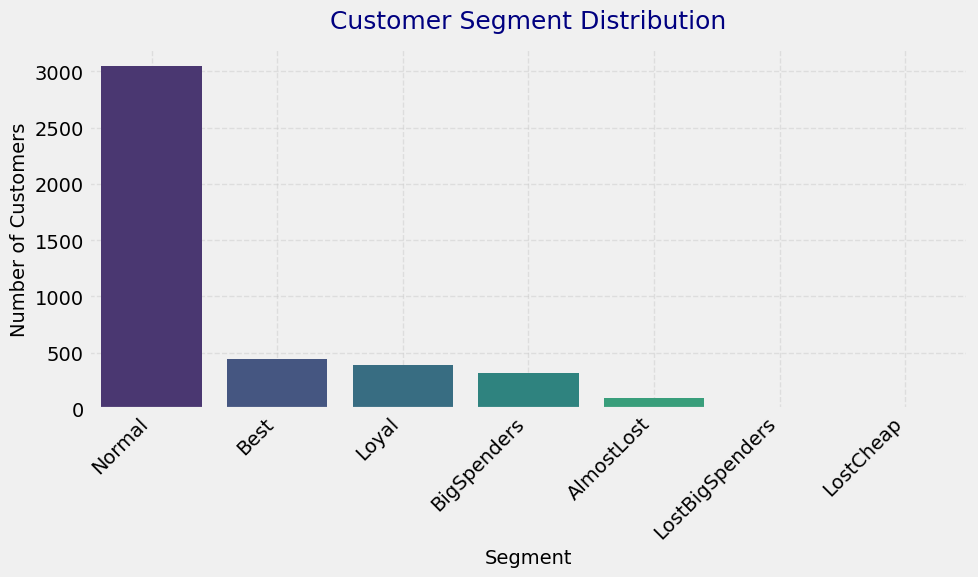

C:\Users\MSI\AppData\Local\Temp\ipykernel_28780\3435954674.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=metric, data=df_customer_segments, palette='muted')
C:\Users\MSI\AppData\Local\Temp\ipykernel_28780\3435954674.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=metric, data=df_customer_segments, palette='muted')
C:\Users\MSI\AppData\Local\Temp\ipykernel_28780\3435954674.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=metric, data=df_customer_segments, palette='muted')


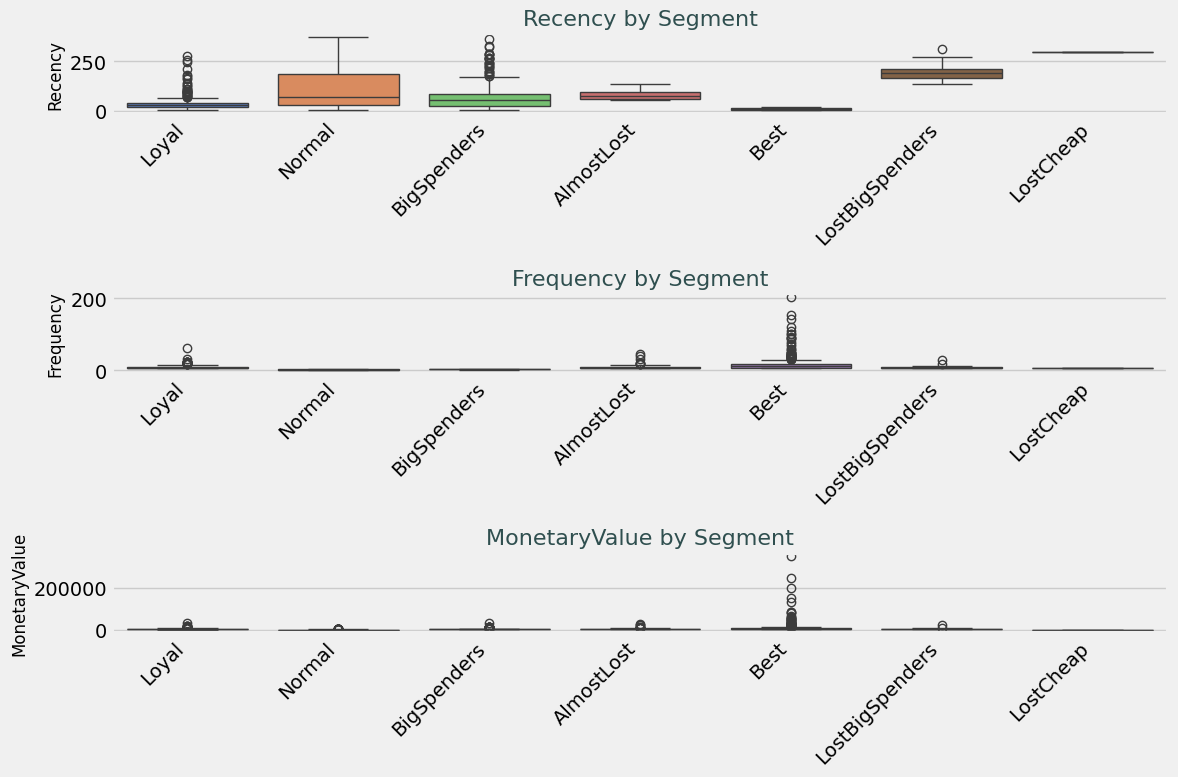

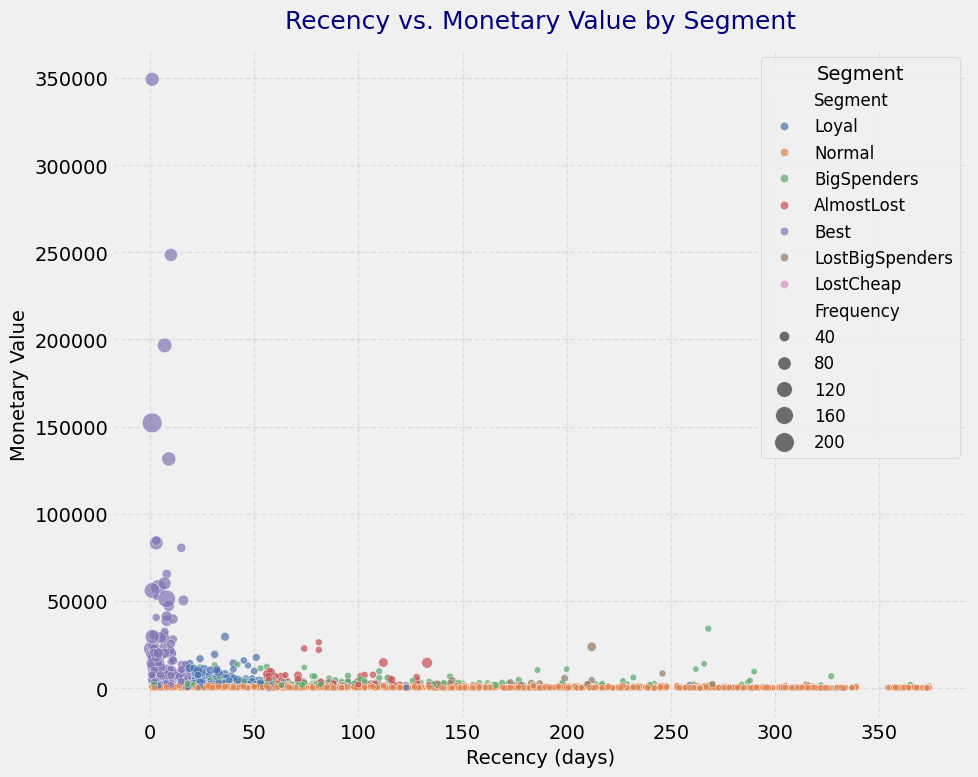

2025-04-10 12:46:49,836 - INFO - Visualization plots generated and saved.


In [9]:
plt.style.use('fivethirtyeight')

# Plot 1: Bar Chart of Segment Distribution
plt.figure(figsize=(10, 6))
segment_counts = df_customer_segments['Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segment Distribution', fontsize=18, color='navy', pad=15)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('segment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Box Plot of RFM Metrics by Segment
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['Recency', 'Frequency', 'MonetaryValue'], 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='Segment', y=metric, data=df_customer_segments, palette='muted')
    plt.title(f'{metric} by Segment', fontsize=16, color='darkslategray')
    plt.xlabel('')
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rfm_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Scatter Plot of Recency vs. Monetary Value
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Recency', y='MonetaryValue', hue='Segment', size='Frequency', 
                data=df_customer_segments, palette='deep', alpha=0.7, sizes=(20, 200))
plt.title('Recency vs. Monetary Value by Segment', fontsize=18, color='navy', pad=15)
plt.xlabel('Recency (days)', fontsize=14)
plt.ylabel('Monetary Value', fontsize=14)
plt.legend(title='Segment', title_fontsize=14, fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('recency_monetary_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Visualization plots generated and saved.")

## Step 10: Prepare Submission

Save the DataFrame, `last_day`, and notebook, then compress them into `result.zip` for submission.

In [ ]:
import zipfile
import joblib

# Save outputs
df_customer_segments.to_csv('df_customer_segments.csv', index=False)
joblib.dump(last_day, 'last_day')

# Compress files
file_names = ['last_day', 'df_customer_segments.csv', 'final_project_4_rfm.ipynb']
with zipfile.ZipFile('result.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for file in file_names:
        zf.write(file)
logger.info("Submission files compressed into 'result.zip'")